# GlassAI data

This notebook processes and analyses Glass AI data for the Creative Nation project. More specifically:

1. We load the data
2. We tidy the data
3. We enrich the data with information about creative industries sectors and official geographies
4. We identify creative industries and creative economy businesses in the data
5. We compare the geography of activity these data offer us with a geography of activity based on official data
6. We examine the creative embeddedness of different sectors and places
7. We analyse the textual information about the companies

## Preamble

In [20]:
%matplotlib inline
#Imports

#Key imports are loaded from my profile (see standard_imports.py in src folder).

#Paths

#Paths
top = os.path.dirname(os.getcwd())

#External data (to download the GRID database)
ext_data = os.path.join(top,'data/external')

#Interim data (to place seed etc)
int_data = os.path.join(top,'data/interim/')

#Figures
fig_path = os.path.join(top,'reports/final_figures')

#Models
mod_path = os.path.join(top,'models/')

#Visualisations
viz_path = os.path.join(top,'src/visualization')


#Get date for saving files
today = datetime.datetime.today()

today_str = "_".join([str(x) for x in [today.day,today.month,today.year]])

In [21]:
import string
digits = string.digits

In [22]:
#Utilities
#This function takes a df with levels of activity and creates one with location quotients.

def sum_elements_in_list_of_lists(list_of_lists):
    '''
    Some times we have lists whose elements are lists of lists (eg a tokenised corpus) where we want to 
    extract the distribution.
    This function does that
    '''
    
    out_sorted = pd.Series([x for el in list_of_lists for x in el]).value_counts(ascending=False)
    return(out_sorted)
    

def create_lq_df(df):
    '''
    Takes a df with cells = activity in col in row and returns a df with cells = lq
    
    '''
    
    area_activity = df.sum(axis=0)
    area_shares = area_activity/area_activity.sum()
    
    lqs = df.apply(lambda x: (x/x.sum())/area_shares, axis=1)
    return(lqs)

## 1. Load data


In [23]:
#Read data
data = pd.read_csv(ext_data+'/org_creative_by_subsectors_v2.txt',sep='\t',header=None)

#Read detailed topic info we were sent
topics = pd.read_csv(ext_data+'/org_creative_topics.txt',sep='\t',header=None)

#Read detailed descriptions we were sent
descs = pd.read_csv(ext_data+'/org_creative_descriptions.txt',sep='\t',header=None)

#Activity in other sectors
gl_all = pd.read_csv(ext_data+'/org_non_creative_ttwa.txt',delimiter='\t',header=None)
gl_all.columns = ['ttwa_code','glass_sector','glass_subsector','business_count']


In [24]:
#Official data

#Load totals
official =pd.read_csv(ext_data+'/11_1_2018_processed_data.csv')


#IDBR data
idbr = official[['sector','bc_2015_2016','ttwa_name','ttwa_code']]

#Cluster list
cluster_list = set(official.ttwa_name[official.is_cluster==True])

### (and metadata)

In [25]:
#Load NSPL data
nspl = pd.read_csv(ext_data+'/NSPL_AUG_2017_UK/Data/NSPL_AUG_2017_UK.csv',
                   usecols=['pcds','ttwa','laua','gor']
                  )
#Load TTWA labels
ttwa_labels = pd.read_csv(ext_data+'/NSPL_AUG_2017_UK/Documents/TTWA names and codes UK as at 12_11 v5.txt',
                          delimiter='\t')
#Tidy labels
ttwa_labels.rename(columns={'TTWA11CD':'ttwa_code','TTWA11NM':'ttwa_name'},inplace=True)


#Load the GlassAI - DCMS table and lowercase columns
gl_to_dcms_df = pd.read_excel(ext_data+'/glass_ai_dcms_lookup.xlsx',sheetname=1)
gl_to_dcms_df.columns = [x.lower() for x in gl_to_dcms_df.columns]

#Rename columns
gl_to_dcms_df.rename(columns={'creative_sector':'dcms_sector'},inplace=True)

#Create a glass ai - dcms sector lookup

gl_to_dcms_df = gl_to_dcms_df.dropna(axis=0,subset=['dcms_sector'])

#This is a dict with keys = glai subsector labels and values = dcms sectors
gl_to_dcms_lookup = {x:y for x,y in zip(gl_to_dcms_df.subsector,
                                        gl_to_dcms_df.dcms_sector)}

#This is a list of all the glai labels associated to a creative subsector
gl_subsectors_creative = list(gl_to_dcms_lookup.keys())

/usr/local/lib/python3.5/site-packages/pandas/util/_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [69]:
#DCMS name lookup so we can merge easily

dcms_names_lookup = {
    'IT, software and computer services':'it_software',
    'Music, performing and visual arts':'music_performing_arts',
    'Film, TV, video, radio and photography':'video_film_photography',
    'Advertising and marketing':'advertising_marketing',
    'Design: product, graphic and fashion design':'design',
    'Architecture':'architecture',
    'Publishing':'publishing',
    'Museums, galleries and libraries':'libraries_museums',
    'Crafts':'crafts',
    'not_creative':'not_in_sector',
    'Creative Industries':'creative_industries'}

#And reversed lookup
dcms_names_lookup_r = {y:x for x,y in dcms_names_lookup.items()}

#And a TTWA code-name lookup
ttwa_code_name_lookup = {x:y for x,y in zip(ttwa_labels.ttwa_code,ttwa_labels.ttwa_name)}

## 2. Process data

In [27]:
#The text file they sent doesn't have columns so we create them here.
gl_columns= [x.lower() for x in ['id','name','GeneratedSector','GeneratedSubsector','GeneratedTag',
          'SourceSector','SourceSubsector','Status','PredictedSector','Topics','PostalTowns','Website']]

#Rename columns
data.columns=gl_columns

#What does this look like?
print(data.shape)

data.head()

(253650, 12)


,id,name,generatedsector,generatedsubsector,generatedtag,sourcesector,sourcesubsector,status,predictedsector,topics,postaltowns,website
0,127859,Just Posh Art,Consumer Goods and Services,Luxury Goods and Jewellery,R1,Consumer Goods and Services,Luxury Goods and Jewellery,U,NaN,NaN,NaN,justposhart.com
1,769601,Ian Daniel,Technology,Information Technology and Services,R1,Technology,Information Technology and Services,C,NaN,NaN,NaN,www.iandaniel.com
2,756583,Delta Coding,Technology,Internet,R1,Technology,Internet,C,NaN,NaN,NaN,www.deltacoding.co.uk
3,757043,DHE Trading,Professional Services,Marketing and Advertising,R1,Professional Services,Marketing and Advertising,C,NaN,NaN,NaN,www.dhetrading.co.uk
4,19351,Aug Visual,Professional Services,Marketing and Advertising,R1,Professional Services,Marketing and Advertising,U,NaN,NaN,NaN,augvisual.com


A couple of observations: 

* Many of the companies don't have postcode data. We will not be able to use them for mapping. 
* Many of the companies don't have topic data. We will not be able to use them for NLP

In [28]:
#Merge data with descriptions
data2 = pd.merge(data,descs,left_on='id',right_on=0).drop(0,axis=1)

#And rename the description variables
data2.rename(columns={1:'description_1',2:'description_2'},inplace=True)

In [29]:
#For each company, gather the long topic list by id into lists and merge the result with our data
topics_gathered = topics.groupby(1)[0].apply(lambda x: list(x))

#Concatenate them
data3 = pd.concat([data2.set_index('id'),topics_gathered],1)

#Rename columns
data3.rename(columns={0:'topics_detailed'},inplace=True)

In [30]:
data3.columns

Index(['name', 'generatedsector', 'generatedsubsector', 'generatedtag',
       'sourcesector', 'sourcesubsector', 'status', 'predictedsector',
       'topics', 'postaltowns', 'website', 'description_1', 'description_2',
       'topics_detailed'],
      dtype='object')

In [31]:
#Rename columns
data3.columns = ['name','creative_gl_sector','creative_gl_subsector','source',
                'source_gl_sector','source_gl_subsector','status','sector_probabilities','topics_short','postcodes',
               'website','description_1','description_2','topics_long']

data3.head()

gl = data3

## 3. Enrich data

* Match postcodes with NSPL
* Match sectors with DCMS lookup

### Postcodes

In [32]:
#The thing here is that we have some companies with lots of postcodes. 

#We have been advised to focus on the first one. This is the postcode that first appears on a page. 

#NB if the type is float (this is a missing value) then we call it that
gl['postcode_1'] = [x.split(",")[0].lower() if type(x)!=float else np.nan for x in gl.postcodes]

#How many companies have postcode data?
len(gl['postcode_1'].dropna())

125845

We have postcodes for ~ half the companies in the data. NB we are keeping everyone, including companies with multiple postcodes

In [33]:
#Merge with nspl
nspl['pcds']=[x.lower() for x in nspl['pcds']]

In [34]:
#Merge Glass AI and NSPL. Drop the geographies we are not planning to use
gl = pd.merge(pd.merge(gl,nspl,left_on='postcode_1',right_on='pcds',how='left'),
                       ttwa_labels,left_on='ttwa',right_on='ttwa_code',how='left').drop(['laua'],axis=1)

### Sectors

GlassAI already extracted some sectors from their topic mix (this is what the source variables R1 and R2 are telling us.). We will not use that and instead extract from the topic mix two things:

* If a company is creative: this is the case if the top subsector is creative AND its probability is above a certain threshold

* If a company is creative embedded: this is the case if the company has creative subsectors with probability above a certain threshold BUT the top subsector is not creative. 



In [35]:
#Only small number of sectors with no probabilities
print(np.sum(gl.sector_probabilities.isna()))

#Oddly the number of missing non creative sectors is much bigger. We'll address this
print(np.sum(gl.creative_gl_sector.isna()))

19369
0


In [36]:
#We will create a function that does all the above:

def extract_creative_sectors(prob_vector,thresholds=[35,25]):
    '''
    This function extracts from a topic mix three things:
    -The creative sector if the company is creative (top subsector is creative and above threshold one)
    -The creative sector if the company is embedded (top subsector is not creative but it has creative
    sectors above threshold)
    
    '''
    
    #First thing: the vector of probabilities can be missing (FIGURE OUT WHY) OR there might be
    #no creartive subsectors in the topic mix (figure out WHY)    
    
    
    if type(prob_vector)==float:
        return([np.nan,np.nan])
    
    else:
        
        #There are some cases where the topic mix has no creative sectors
        has_creative = np.sum([x[0] in gl_subsectors_creative for x in prob_vector])>0
        
        if has_creative == False:
            return([np.nan,np.nan])
        
        else:
            #Here we need to first of all aggregate the probabilities by gl subsector.
            probs = pd.DataFrame(prob_vector,columns=['sector','value'])
            
            #print(probs)

            #Lookup glass ai subsectors vs creative
            probs['dcms'] = [gl_to_dcms_lookup[x] if x in gl_subsectors_creative else 'not_creative' 
                             for x in probs['sector']] 

            #Aggregate. NB here we aggregate all not creative into a single sector that creative competes with.
            probs_aggregate = probs.groupby('dcms')['value'].sum().sort_values(ascending=False)

            #Is the first sector creative and above the threshold?
            if probs_aggregate.index[0] !='not_creative' and probs_aggregate[0]>thresholds[0]:
                creative_sector = str(probs_aggregate.index[0])

                #If you are creative specialist, you can't be embedded
                creative_embedded= np.nan

            else:
                creative_sector = np.nan

                #And look for creative embedded sectors
                if 'not_creative' in probs_aggregate.index:
                    probs_creative = probs_aggregate.drop('not_creative')
                else:
                    probs_creative = probs_aggregate

                if probs_creative[0]>thresholds[1]:
                    creative_embedded = str(probs_creative.index[0])
                else:
                    creative_embedded = np.nan

            return([creative_sector,creative_embedded])

In [37]:
#We neeed to create an alternative sector probabilities variable removing commas (commas also used to separate
#sectors in the sector probability variable)

gl['sub_sector_probs_clean'] = [re.sub(", "," " ,x) 
                                    if type(x)==str else np.nan for x in gl.sector_probabilities]

#gl probabilities is a list where every element is a list of subsectors and probabilities
gl_subs_probabilities = [
    [[el.split(':')[1],float(el.split(':')[2])] for el in x.split(",")] 
    if type(x)==str else np.nan for x in gl['sub_sector_probs_clean']]


In [38]:
#We also need to fix the problem with the lack of sector probabilities for lots of sectors
gl_sect_probabilities = [
    [[el.split(':')[0],float(el.split(':')[2])] for el in x.split(",")] 
    if type(x)==str else np.nan for x in gl['sub_sector_probs_clean']]

gl['gl_top_sector'] = [x[0][0] if type(x)!=float else np.nan for x in gl_sect_probabilities]

In [39]:
#Extract creative specialisation and embeddedness
gl_creative_classification = [extract_creative_sectors(x) for x in gl_subs_probabilities]

In [40]:
#Put the outputs in the gl dataframe
gl['creative_spec'] = [x[0] for x in gl_creative_classification]

gl['creative_embed'] = [x[1] for x in gl_creative_classification]

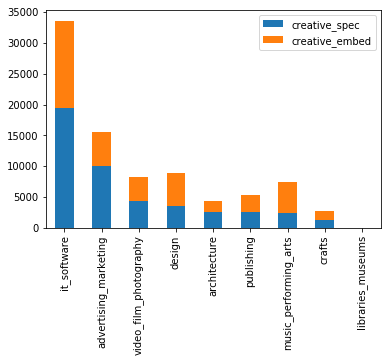

In [41]:
fig,ax = plt.subplots()

pd.concat([gl.creative_spec.value_counts(),gl.creative_embed.value_counts()],axis=1).sort_values(
    'creative_spec',ascending=False).plot.bar(ax=ax,stacked=True)

In [42]:
gl.creative_spec.value_counts().sum()+gl.creative_embed.value_counts().sum()

86481

So we end with around 86K companies

In [43]:
#This does some checking
def extract_companies_in_sector(sector,variable,n=5):
    '''
    Extracts some companies from a sector for visual inspection
    
    '''
    #Select the sector in the variable
    out = gl.loc[gl[variable]==sector,:].reset_index(drop=False)
    
    #print(out)
    indices_to_extract = np.random.randint(0,len(out),size=n)
    
    return(out.loc[indices_to_extract,['name','topics_list','long_topics','description_1','description_2']])
    
    

In [44]:
extract_companies_in_sector('crafts','creative_embed',n=10).head()

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


,name,topics_list,long_topics,description_1,description_2
1461,A.W.PORTER & SON,NaN,NaN,NaN,The Business was established in 1844 by Alfred...
554,Gilded Lili Gifts,NaN,NaN,NaN,Gilded Lili Gifts strives to provide a constan...
345,Birch & Brook,NaN,NaN,"Inspired by the story telling power of scent, ...","Fortnum & Mason, the iconic luxury department ..."
1,Accessories Online,NaN,NaN,"Visit Accessories Online for unique costume, d...",This entry was posted in News and tagged acces...
806,Earth Seed To Bloom,NaN,NaN,The only Chichester florist to choose for wedd...,Flowers can be used in a business environment ...


## 4. Analysis  - sectoral overlaps

Create heatmap / bubblechart of creative embeddedness in non-creative sectors


In [45]:
#UK creative economy activity totals

import matplotlib as mpl

#This gives us creative embedded companies by non-creative sector
national_creative_mix= pd.melt(
    pd.crosstab(gl.gl_top_sector,gl.creative_embed).reset_index(drop=False),
    id_vars='gl_top_sector')

#UK non-creative totals
national_non_ce = gl_all.groupby('glass_sector').sum()

#Merge creative embedded and non-creative
national_creative_mix = pd.merge(national_creative_mix,national_non_ce.reset_index(drop=False),
                                left_on='gl_top_sector',right_on='glass_sector')

#This captures the share of embedded businesses in the total of a sector
national_creative_mix['share'] = national_creative_mix['value']/(
    national_creative_mix['value']+national_creative_mix['business_count'])

In [46]:
#Create a bubble chart.

#This uses a matrix with total number of embedded companies for the bubble sizes and
#another with the relative shares for the colors.

#Create size matrix
size_matrix = pd.pivot_table(national_creative_mix,
                             index='creative_embed',columns='glass_sector',values='value')

#Create color matrix
share_matrix = pd.pivot_table(national_creative_mix,
                                    index='creative_embed',columns='glass_sector',values='share').rank(axis=0)

#Create colormap
cw = mpl.cm.coolwarm

#Extract intervals and create a dictionary with the ranks in the color matrix
#We can then call the dictionary based on the score of a cell in the share matrix

intervals = [int(x) for x in np.linspace(0,256,len(set(share_matrix.values.ravel())))]
color_dict = {num:cw(x) for num,x in zip(sorted(list(set(share_matrix.values.ravel()))),intervals)}


In [47]:
def rescale(vector,vmin,vmax):
    '''
    Rescales a vector with a new minimum and maximum. We do this to avoid complerte domination of the
    bubble chart by a small number of sectors
    
    '''
    
    try:
        rescaled = [((x - min(vector)) / (max(vector) - min(vector) )) * (vmax - vmin) + vmin for x in vector]
    except:
        #The above will fail if the vector is all zeroes (it tries to divide by zero)
        #In that case, we return a vector of zeroes
        
        rescaled = len(vector)*[0]
    
    return(rescaled)

def create_bubblechart(size_matrix,
                       color_matrix,
                       ax):
    '''
    This function takes a couple of matrices with the sizes of the bubbles and their colours
    and creates a bubble chart.
    
    '''
    #Need to lay down the x and y coordinates
    #Creates a grid with the coordinates for all points. 
    
    X,Y = np.meshgrid(np.arange(0,len(size_matrix.columns)),np.arange(0,len(size_matrix)))

    #Extract the coordinates
    x = X.ravel()
    y = Y.ravel()


    #Create size variable
    z_not_norm = np.array(size_matrix).ravel()
    
    #Rescale (this is to avoid complete dominance of the chart by a small number of big variables)
    z_norm = [x if x>50 else 0 for x in rescale(z_not_norm,50,1800)]
    
    
    #Create color array
    g = np.array(color_matrix).ravel()
    
    #Loop and fill
    for i in np.arange(0,len(x)):
        
        ax.scatter(x[i],y[i],s=z_norm[i],
                   c=color_dict[g[i]],
                   linewidths=0.5,marker='s',edgecolors='black',
                  )

    #Y axis and ticks
    ax.set_yticks(np.arange(0,len(size_matrix)))
    ax.set_yticklabels(size_matrix.index,fontsize=12)

    #X axis and ticks
    ax.set_xticks(np.arange(0,len(size_matrix.columns),1))

    ax.set_xticklabels(size_matrix.columns,fontsize=12,rotation=90)

    
    

In [48]:
#We created sorted indices and columns to sort scales in the matrix

#Here the creative sectors with more embeddedness in other sectors, and the 
#non creative sectors with more embeddedness from creative are in the top left.
creative_embeddedness_creative_ranking = size_matrix.sum(axis=1).sort_values(ascending=False).index
creative_embeddedness_non_creative_ranking = size_matrix.sum(axis=0).sort_values(ascending=False).index

#We also want to get some values in the distribution of businesses for the bubble size legend
size_key_values = [np.max(np.array(size_matrix).ravel()),8000,1000,
                 np.mean(np.array(size_matrix).ravel()),100,
                 np.min(np.array(size_matrix).ravel())]

bubble_legend = rescale(size_key_values,50,1800)

print(size_key_values)
print(bubble_legend)

[9516, 8000, 1000, 293.4537037037037, 100, 0]
[1800.0, 1521.2063892391761, 233.90079865489702, 103.96637047934863, 68.390079865489696, 50.0]


/usr/local/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


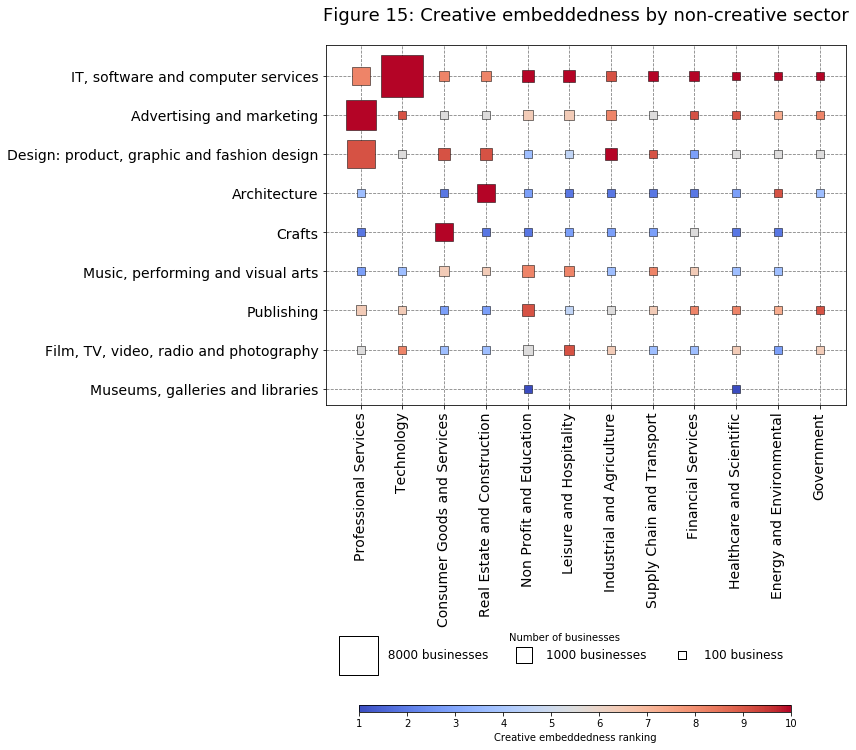

In [103]:
fig,ax = plt.subplots(figsize=(12,9))

#We want the grid below the axis
ax.set_axisbelow(True)

#Use the function we defined above to create the bubble chart
create_bubblechart(
    #Marker size
    size_matrix.loc[reversed(creative_embeddedness_creative_ranking),
                                   creative_embeddedness_non_creative_ranking],
    #Marker color
                   share_matrix.loc[reversed(creative_embeddedness_creative_ranking),
                                  creative_embeddedness_non_creative_ranking],ax=ax)


#Tidy labels and title
ax.set_yticklabels([dcms_names_lookup_r[x.get_text()] for x in ax.get_yticklabels()],fontsize=14)
ax.set_title('Figure 15: Creative embeddedness by non-creative sector',size=18,y=1.05)

ax.set_xticklabels([x.get_text() for x in ax.get_xticklabels()],fontsize=14)

#Add the grid
plt.grid(linestyle='--',linewidth=0.8,color='grey')

#Add custom legend with some invisible scatters
d1 = plt.scatter([],[], s=1521, marker='s',color='white',edgecolor='black')
d2 = plt.scatter([],[], s=233, marker='s',color='white',edgecolor='black')
d3 = plt.scatter([],[], s=68, marker='s',color='white',edgecolor='black')
 
#Add legend
ax.legend((d1,d2,d3),
           #Leave some whitespace for the big circle
           ('  8000 businesses', 
            '1000 businesses', 
            '100 business'),
           scatterpoints=1,ncol=3,
           title='Number of businesses',
           bbox_to_anchor=(
               0.9,-0.6),
           fontsize=12,frameon=False)

#Create the colorbar (custom)
#Add axes
cbar_ax = fig.add_axes([0.42, -0.115, 0.5, 0.01])

#Add colorbar
norm = mpl.colors.Normalize(vmin=1,vmax=10)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap='coolwarm',
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Creative embeddedness ranking')
cb1.ax.xaxis.set_ticks_position('bottom')
cb1.ax.xaxis.set_label_position('bottom')


plt.tight_layout()

plt.savefig(fig_path+'/{date}_figure_15_creative_embeddedness.pdf'.format(date=today_str),bbox_inches='tight')


### Create area statistics

Here we produce creative area stats by creative specialisation and embeddedness


#### Relation between creative specialisation and creative embeddedness

In [50]:
from scipy.stats import linregress

In [51]:
def generate_ttwa_counts(df,filter_variable,totals=False):
    '''
    This function creates TTWA counts for creative specialisation / creative embedded companies 
    in total or by sector. We can combine this with glass ai totals to produce LQs later
    
    '''
    
    #Filter by the variable
    df_filtered = df.dropna(axis=0,subset=[filter_variable])
    
    #Group
    df_grouped = df_filtered.groupby(
            ['ttwa_code',filter_variable]).size().reset_index(drop=False)
    df_grouped.rename(columns={0:'business_count',filter_variable:'sector'},inplace=True)
    
    #Rename sector names depending on whether we are looking at specialist or embedded
    df_grouped['sector'] = [x+'_spec' if filter_variable=='creative_spec' else x+'_embed' for x in df_grouped['sector']]
    
    #Do we want totals?
    if totals==True:
        df_totals = df_grouped.groupby('ttwa_code')['business_count'].sum()
        df_totals.name = filter_variable.split("_")[0]+'_industries_'+filter_variable.split("_")[1]
        return(df_totals)
        
        
    else:
        df_wide = pd.pivot_table(df_grouped,index='ttwa_code',columns='sector',values='business_count')
        df_wide.fillna(value=0,inplace=True)
        return(df_wide)
    
def plot_regression_line(var_1,var_2):
    '''
    This function returns the coordinates for plotting a regression line in a scatter like the
    ones we create below
    
    '''
    
    reg = linregress(var_1,var_2)
    
    x_to_plot = [0,np.max(var_1)]
    
    
    y_to_plot = [reg[1],reg[0]*np.max(var_2)+reg[1]]
    
    legend =     'x={inter}+{coef}*y \n $R^2$={r2}'.format(
        inter=str(np.round(reg[1],2)),
        coef = str(np.round(reg[0],2)),r2=str(np.round(reg[2],2)))

    
    return([reg,x_to_plot,y_to_plot,legend])

    

In [68]:
dcms_names_lookup

{'Advertising and marketing': 'advertising_marketing',
 'Architecture': 'architecture',
 'Crafts': 'crafts',
 'Creative Industries': 'creative_industries',
 'Design: product, graphic and fashion design': 'design',
 'Film, TV, video, radio and photography': 'video_film_photography',
 'IT, software and computer services': 'it_software',
 'Museums, galleries and libraries': 'libraries_museums',
 'Music, performing and visual arts': 'music_performing_arts',
 'Publishing': 'publishing',
 'not_in_sector': 'not_creative'}

In [71]:
#Totals in area (non creative)
gl_all_ttwa = gl_all.groupby('ttwa_code')['business_count'].sum()
gl_all_ttwa.name = 'non_creative_totals'

#IDBR LQs
idbr_lqs = create_lq_df(pd.pivot_table(idbr,index='ttwa_code',columns='sector',values='bc_2015_2016')).fillna(0)
idbr_lqs.rename(columns={'All creative industries':'Creative Industries'},inplace=True)

idbr_lqs.columns = [dcms_names_lookup[x]+'_idbr' for x in idbr_lqs.columns]

idbr_lqs.head()

,advertising_marketing_idbr,creative_industries_idbr,architecture_idbr,design_idbr,video_film_photography_idbr,it_software_idbr,music_performing_arts_idbr,publishing_idbr,not_in_sector_idbr
ttwa_code,,,,,,,,,
E30000004,0.695222,0.655480,0.542228,0.759942,0.543337,0.654113,0.679414,1.291552,1.063581
E30000018,0.657625,0.673865,0.746043,0.871327,0.395772,0.775849,0.524052,0.637907,1.060247
E30000029,0.817258,0.888360,0.831401,1.009859,0.548867,0.989890,0.858654,1.056183,1.019864
E30000039,0.000000,0.579130,1.661190,0.776062,0.391667,0.522106,0.567676,0.000000,1.084340
E30000046,0.650516,0.738752,0.913249,0.924396,0.669889,0.540293,1.433270,1.487383,1.047441


In [72]:
#Combine all business counts and calculate LQs
gl_spec_subs = create_lq_df(pd.concat([generate_ttwa_counts(gl,'creative_spec'),
                         generate_ttwa_counts(gl,'creative_embed'),gl_all_ttwa],axis=1)).fillna(0)

gl_spec_sect = create_lq_df(pd.concat([generate_ttwa_counts(gl,'creative_spec',totals=True),
                         generate_ttwa_counts(gl,'creative_embed',totals=True),gl_all_ttwa],axis=1)).fillna(0)

#Concatenate everything
gl_spec = pd.concat([gl_spec_subs,gl_spec_sect],axis=1).drop('non_creative_totals',axis=1)

#Here it is.
gl_spec['ttwa_name'] = [ttwa_code_name_lookup[x] for x in gl_spec.index] 

#Combine IDBR too
spec_all = pd.concat([gl_spec,idbr_lqs],axis=1)

In [73]:
spec_all

,advertising_marketing_spec,architecture_spec,crafts_spec,design_spec,it_software_spec,libraries_museums_spec,music_performing_arts_spec,publishing_spec,video_film_photography_spec,advertising_marketing_embed,...,ttwa_name,advertising_marketing_idbr,creative_industries_idbr,architecture_idbr,design_idbr,video_film_photography_idbr,it_software_idbr,music_performing_arts_idbr,publishing_idbr,not_in_sector_idbr
E30000004,0.457782,0.179525,0.000000,0.756497,0.647396,0.0,0.272205,0.392717,0.308940,0.622927,...,Barnsley,0.695222,0.655480,0.542228,0.759942,0.543337,0.654113,0.679414,1.291552,1.063581
E30000018,0.738938,0.745160,1.375731,0.785003,0.847040,0.0,1.129847,1.833820,0.320581,0.808000,...,Bradford,0.657625,0.673865,0.746043,0.871327,0.395772,0.775849,0.524052,0.637907,1.060247
E30000029,1.193286,0.842333,1.036757,1.242321,0.825431,0.0,1.596483,0.460658,1.449548,0.243565,...,Halifax,0.817258,0.888360,0.831401,1.009859,0.548867,0.989890,0.858654,1.056183,1.019864
E30000039,0.703071,1.861102,0.000000,0.522830,0.583602,0.0,2.821892,1.357074,1.067572,0.717529,...,Skipton,0.000000,0.579130,1.661190,0.776062,0.391667,0.522106,0.567676,0.000000,1.084340
E30000046,0.357986,0.631750,1.036757,0.354949,0.363190,0.0,1.277187,0.690987,0.362387,0.487130,...,Dorchester and Weymouth,0.650516,0.738752,0.913249,0.924396,0.669889,0.540293,1.433270,1.487383,1.047441
E30000051,1.286544,1.397175,0.000000,1.766256,0.657186,0.0,1.588848,1.146137,0.601090,0.606000,...,Falmouth,0.816341,0.726435,0.000000,1.784672,0.750582,0.388449,1.160406,1.866537,1.053647
E30000054,0.741086,0.747326,0.000000,0.944742,0.527278,0.0,0.000000,1.634801,0.643026,0.432186,...,Grantham,0.693166,0.719629,1.081248,1.231252,0.509863,0.689660,0.615822,1.188675,1.050932
E30000061,0.640054,0.564763,1.390238,0.475968,0.487019,0.0,2.140803,0.000000,0.000000,0.326608,...,Hastings,0.900983,0.989013,1.405416,1.453837,1.072983,0.697839,1.707629,1.569575,0.999641
E30000064,2.016881,1.016931,0.000000,0.857044,0.318888,0.0,0.000000,0.000000,0.875004,0.588101,...,Hexham,0.000000,0.631577,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.129059
E30000070,0.563182,0.000000,0.815511,0.558404,0.779139,0.0,1.506948,0.000000,0.285053,0.957938,...,Isle of Wight,0.599582,0.660583,1.143107,0.655398,0.490030,0.599431,0.804939,1.370924,1.062956


In [80]:
#These are the creative sector names
creative_sector_names = ['creative_industries']+list(creative_embeddedness_creative_ranking)
creative_sector_names.remove('libraries_museums')
creative_sector_names.remove('crafts')

In [81]:
creative_sector_names

['creative_industries',
 'it_software',
 'advertising_marketing',
 'design',
 'architecture',
 'music_performing_arts',
 'publishing',
 'video_film_photography']

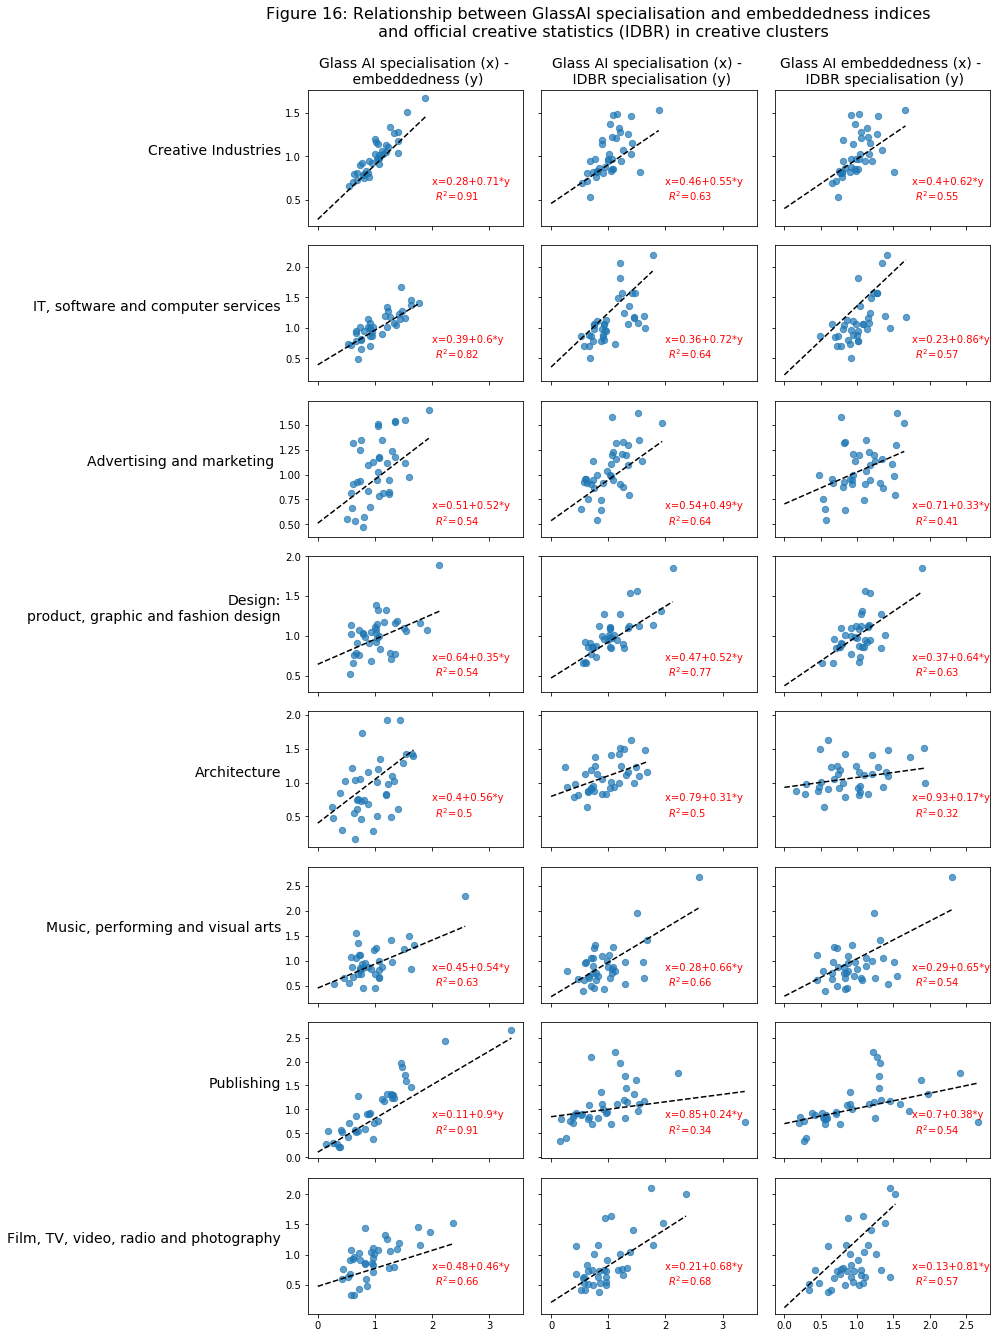

In [106]:
#So what's the visualsation?

fig,ax = plt.subplots(nrows = len(creative_sector_names),ncols=3,figsize=(14,18),
                      sharex='col',sharey='row'
                     )

for num,x in enumerate(creative_sector_names):    
    relevant_df = spec_all.loc[[x in cluster_list for x in spec_all.ttwa_name],[x in col for col in spec_all.columns]]
    
    
    #First plot
    ax[num][0].scatter(relevant_df[x+'_spec'],relevant_df[x+'_embed'],s=40,alpha=0.7)
    
    #Regress and plot!
    coords = plot_regression_line(relevant_df[x+'_spec'],relevant_df[x+'_embed'])
    ax[num][0].plot(coords[1],coords[2],color='black',linestyle='--')
    
    #Add legend
    ylabs = ax[num][0].get_yticks()
    ax[num][0].annotate(xy=(2,0.5),s=coords[3],color='red')
    
    
    ax[num][1].scatter(relevant_df[x+'_spec'],relevant_df[x+'_idbr'],s=40,alpha=0.7)
    
    coords_2 = plot_regression_line(relevant_df[x+'_spec'],relevant_df[x+'_idbr'])
    ax[num][1].plot(coords_2[1],coords_2[2],color='black',linestyle='--')
    ax[num][1].annotate(xy=(2,0.5),s=coords_2[3],color='red')
    
    
    ax[num][2].scatter(relevant_df[x+'_embed'],relevant_df[x+'_idbr'],s=40,alpha=0.7)
    #ax[num][2].set_ylim(-0.5)

    coords_3 = plot_regression_line(relevant_df[x+'_embed'],relevant_df[x+'_idbr'])
    ax[num][2].plot(coords_3[1],coords_3[2],color='black',linestyle='--')
    ax[num][2].annotate(xy=(1.75,0.5),s=coords_3[3],color='red')
    
    
    

    
for num,sector in enumerate(creative_sector_names):
    ax[num][0].set_ylabel(':\n '.join(dcms_names_lookup_r[sector].split(':')),rotation=0,ha='right',fontsize=14)

    
for num,title in zip([0,1,2],['Glass AI specialisation (x) - \n embeddedness (y)',
                        'Glass AI specialisation (x) - \n IDBR specialisation (y)',
                        'Glass AI embeddedness (x) - \n IDBR specialisation (y)']):
    ax[0][num].set_title(title,fontsize=14)


fig.suptitle(
    'Figure 16: Relationship between GlassAI specialisation and embeddedness indices \n and official creative statistics (IDBR) in creative clusters',
            size=16,y=1.03,x=0.6)    

plt.tight_layout()

plt.savefig(fig_path+'/{date}_figure_16_glass_idbr_correlations.pdf'.format(date=today_str),bbox_inches='tight')


In [85]:
pd.crosstab(spec_all.creative_industries_spec>1,spec_all.creative_industries_embed>1,normalize=0)

creative_industries_embed,False,True
creative_industries_spec,,
False,0.867725,0.132275
True,0.317073,0.682927


## Local analysis

Produce a chart to visualise creative embeddedness in different TTWAS


In [86]:
import matplotlib.patches as mpatches

In [87]:
#Get creative embedded share by city

embedded_by_ttwa = gl.dropna(axis=0,subset=
                             ['creative_embed']).groupby(['gl_top_sector','ttwa_name'])['creative_embed'].count().reset_index(drop=False)

#Create DF
embedded_clusters = pd.pivot_table(
    embedded_by_ttwa.loc[[x in cluster_list for x in embedded_by_ttwa.ttwa_name],:],
    index='ttwa_name',columns='gl_top_sector',values='creative_embed').fillna(0).drop('Media and Arts',axis=1)

#Calculate shares of all ambedded
embedded_shares = embedded_clusters.apply(lambda x: x/x.sum(),axis=1)

#Create rankings to sort variables
non_creative_sorted = embedded_clusters.sum().sort_values(ascending=False).index

cluster_sorted = embedded_clusters.sum(axis=1).sort_values(ascending=True).index

In [88]:
embedded_totals = embedded_clusters.sum(axis=1)[cluster_sorted]

In [89]:
#Share of embedded in cluster

embedded_detailed = gl.dropna(
    axis=0,subset=['creative_embed']).groupby(
    ['gl_top_sector','ttwa_name','creative_embed'])['name'].count().reset_index(drop=False)


embedded_detailed = embedded_detailed.loc[[x in cluster_list for x in embedded_detailed.ttwa_name],:]


embedded_detailed['share'] = 100*embedded_detailed.groupby(['ttwa_name','gl_top_sector'])['name'].apply(lambda x:x/x.sum())

In [90]:
#We also want to calculate embedded as a share of total
#This captures non creative
gl_all_ttwa_df = pd.DataFrame(gl_all_ttwa)
gl_all_ttwa_df.index = [ttwa_code_name_lookup[x] for x in gl_all_ttwa_df.index]

#This includes specialist firms
specialist_intensity = gl.dropna(axis=0,subset=['creative_spec']).groupby('ttwa_name')['name'].count()

#This includes embedded firms and specialist firms
embedded_intensity = pd.concat([specialist_intensity,embedded_clusters.sum(axis=1),gl_all_ttwa_df],axis=1).dropna()

#Rename columns
embedded_intensity.columns = ['specialist','embedded','non_creative']

embedded_intensity['creative_intensity'] = embedded_intensity['specialist']/embedded_intensity.sum(axis=1)
embedded_intensity['embedded_intensity'] = embedded_intensity['embedded']/embedded_intensity['non_creative']


In [91]:
#Create color palette and dict
non_c_sector_color = mpl.cm.Pastel2_r
non_sector_color_dict = {x:non_c_sector_color(num) for num,x in enumerate(non_creative_sorted)}

c_sector_color = mpl.cm.tab10
c_sector_color_dict = {x:c_sector_color(num) for num,x in enumerate(creative_embeddedness_creative_ranking)}

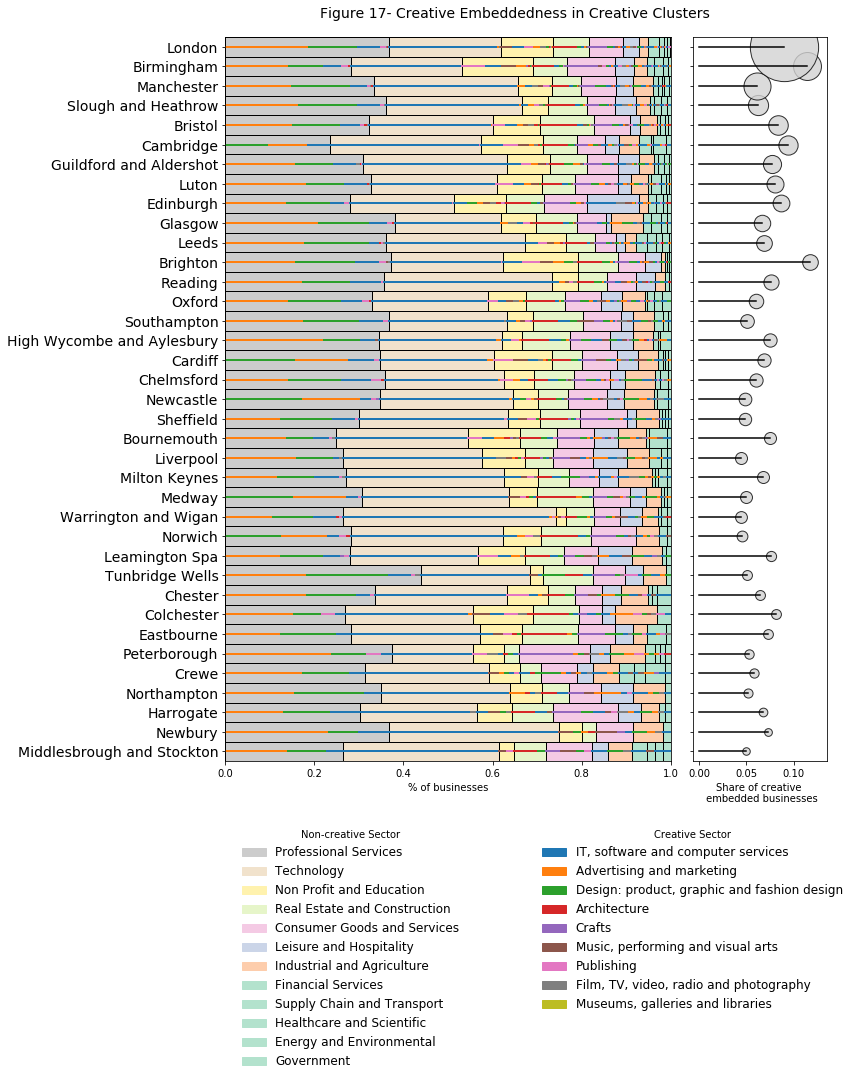

In [107]:
fig,ax = plt.subplots(figsize=(12,11),ncols=3,sharey=True,gridspec_kw={'width_ratios':[1,0.3,0]})

check=[]

#Create a stacked barplot and draw lines which represent the share of different creative subsectors 
#in each TTWA

#For each TTWA
for num,x in enumerate(cluster_sorted):
    levels = embedded_shares.loc[x]
    left = 0
    for y in non_creative_sorted:
        ax[0].barh(num,width=levels[y],left=left,color=non_sector_color_dict[y],height=1,edgecolor='black')
        
        
        #Creative shares in sector
        local_creative_shares = embedded_detailed.loc[(embedded_detailed.ttwa_name==x) &
                                                     (embedded_detailed.gl_top_sector==y),
                                                      ['share','creative_embed']].set_index('creative_embed')
        
        #local_creative_shares.loc['start','share']=left
        local_creative_shares.sort_values('share',ascending=False,inplace=True)
        local_creative_shares['sum'] = local_creative_shares['share'].cumsum()
        local_creative_shares.loc['start','sum']=left
        local_creative_shares.sort_values('sum',ascending=True,inplace=True)
        local_creative_shares['coords'] = rescale(local_creative_shares['sum']/100,left,left+levels[y])
        
        local_creative_shares['ttwa']=x
        local_creative_shares['sector']=y
        
        
        check.append(local_creative_shares)
        
        left=left+levels[y]
        
        #my_index=0
        #print('')
        #print(x)
        #print('')
        for number,cr in enumerate(local_creative_shares.index[1:]):
            
            #start=

            #print(str(number)+'_'+cr)
            ax[0].plot(
                [local_creative_shares.iloc[number,2],local_creative_shares.iloc[number+1,2]],
                [num,num],
                color=c_sector_color_dict[cr],linewidth=2)
                
                #y=num,
                #xmin=local_creative_shares.iloc[my_index,2],
                #xmax=local_creative_shares.loc[cr,'coords'],
                #color=c_sector_color_dict[cr])
            
            #index+=1
            
    ax[1].plot([0,embedded_intensity.loc[x,'embedded_intensity']],[num,num],color='black')
        
    ax[1].scatter(y=num,x=embedded_intensity.loc[x,'embedded_intensity'],color='lightgrey',edgecolor='black',
                  s=embedded_intensity.loc[x,'embedded'],marker='o',alpha=0.8)
        

    ax[2].axes.set_visible(False)    
    
    
#Adjust axes            
[ax[num].set_ylim(-0.5,len(cluster_sorted)-0.5) for num in [0,1]]
[ax[num].set_yticks(np.arange(len(cluster_sorted))) for num in [0,1]]
[ax[num].set_yticklabels(cluster_sorted,fontsize=14) for num in [0,1]]


ax[0].set_xlabel('% of businesses')
ax[1].set_xlabel('Share of creative \n embedded businesses')

plt.subplots_adjust(wspace=0.01)
plt.tight_layout()


#Legend joy
patches_not_c = [ mpatches.Patch(color=
                           non_sector_color_dict[i], 
                           label=i) for i in non_creative_sorted]

patches_c = [ mpatches.Patch(color=
                           c_sector_color_dict[i], 
                           label=i) for i in creative_embeddedness_creative_ranking]

ax[0].legend(patches_not_c,non_creative_sorted,title='Non-creative Sector',bbox_to_anchor=(0.55,-0.08),frameon=False,
            fontsize=12)
ax[1].legend(patches_c,[dcms_names_lookup_r[x] for x in creative_embeddedness_creative_ranking],
             title='Creative Sector',bbox_to_anchor=(1.2,-0.08),frameon=False,fontsize=12)


#Hacky thing
#ax[0].legend(mpatches.Patch.,non_creative_sorted,title='Non-creative Sector',bbox_to_anchor=(1.38,1),frameon=False,
#            fontsize=12)

fig.suptitle('Figure 17- Creative Embeddedness in Creative Clusters',fontsize=14,y=1.02,x=0.6)

plt.savefig(fig_path+'/{date}_figure_17_embeddedness_clusters.pdf'.format(date=today_str),bbox_inches='tight')


In [93]:
#Report stats

print(len(gl.creative_spec.dropna()))

print(len(gl.creative_embed.dropna()))

46262
40219


In [94]:
7/2.3

3.0434782608695654

In [95]:
5/1.1

4.545454545454545

In [96]:
?np.where